# Week 7

In [40]:
import json
import os.path
import networkx as nx
from networkx.readwrite import json_graph
import pandas as pd

## Part 2: Words that characterize the universes

### Exercise 1: Comparing word-counts of Marvel and DC heroes.

#### Setup. You'll need to go to your archives and find the wikipedia pages of all the superheroes.

In [41]:
df_superhero = pd.read_csv('df_superhero.csv', index_col=0)
df_superhero.tail()

,Unnamed: 0,CharacterName,WikiLink,file,universe,WikiOutLinks,TextLen
2365,2365,Zombie,['Zombie (comics)'],Zombie_%28comics%29.json,marvel,"['Special:ApiFeatureUsage', 'Tales of the Zomb...",2491
2367,2367,Carlo Zota,['Enclave (comics)'],Enclave_%28comics%29.json,marvel,"['Special:ApiFeatureUsage', 'Marvel Comics', '...",3413
2368,2368,Zuras,['list of Eternals'],list_of_Eternals.json,marvel,"['Special:ApiFeatureUsage', 'Eternals (comics)...",3315
2370,2370,Zzzax,['Zzzax'],Zzzax.json,marvel,"['Special:ApiFeatureUsage', 'Hulk', 'The Incre...",1675
2371,2371,3-D Man,['3-D Man'],3-D_Man.json,marvel,"['Special:ApiFeatureUsage', 'superhero', 'Amer...",3396


#### Once you have the texts ready, you will want to aggregate the text into two long lists (let's call them two documents). One based on all the text from the Marvel pages, and one based on all the text from the DC pages. In each list, you should keep all the words (or tokens to be more precise) that occur on the pages, and a count of how frequently each word occurs

In [42]:
# Split dataframe into two dataframes of each universe
marvel_df, dc_df = [x for _, x in df_superhero.groupby(df_superhero['universe'] == 'dc')]

In [43]:
import nltk

def read_files_into_string(filenames):
    strings = []
    for filename in filenames:
        with open('../wikidata/{}'.format(filename), 'r') as f:
            strings.append(f.read())
    return '\n'.join(strings)
    
marvel_text = read_files_into_string(marvel_df['file'])
dc_text = read_files_into_string(dc_df['file'])

#### This list is called a Term Frequency (or TF) list. Let's build our own TF lists. Before you start counting, I am going to ask you do do a few things
* Tokenize the pages into individual strings
* Remove all punctuation from your list of tokens
* Set everything to lower case

#### If you are confused by the instructions for cleaning, go back and have a look Chapter 3 again.
* Create your TF list for each universe.
* List the top 15 words for each universe.
* Comment on the top 15 words for each universe.

In [44]:
from nltk.tokenize import word_tokenize

# Tokenize the text to be able to process words
marvel_tokens = word_tokenize(marvel_text)
dc_tokens = word_tokenize(dc_text)

In [45]:
# Most common words from the marvel texts
fdist_marvel = nltk.FreqDist(word.lower() for word in marvel_tokens if word.isalpha())
fdist_marvel.most_common(15)

[('the', 189149),
 ('and', 89420),
 ('to', 86677),
 ('of', 84778),
 ('a', 61994),
 ('in', 61426),
 ('ref', 46849),
 ('marvel', 44226),
 ('comics', 42705),
 ('by', 33930),
 ('his', 33769),
 ('is', 31358),
 ('he', 29665),
 ('as', 26790),
 ('with', 26505)]

In [46]:
# Most common words from the dc texts
fdist_dc = nltk.FreqDist(word.lower() for word in dc_tokens if word.isalpha())
fdist_dc.most_common(15)

[('the', 79380),
 ('of', 39829),
 ('and', 36216),
 ('to', 35526),
 ('in', 29719),
 ('a', 27857),
 ('comics', 15829),
 ('is', 14821),
 ('by', 14488),
 ('his', 14437),
 ('ref', 12971),
 ('as', 12925),
 ('he', 12572),
 ('dc', 11895),
 ('with', 10983)]

## Part 3: Visualization

#### Draw some wordclouds
* Get your lists ready for the word-cloud software
    * The package needs a single string to work on. The way that I converted my lists to a string was to simply combine all words together in one long string (separated by spaces), repeating each word according to its score (rounded up to the nearest integer value).
    * The wordcloud package looks for collocations in real texts, which is a problem when you make the list as above. The recommended fix is to simply set collocations = False as an option when you run the package.

In [47]:
# Add words to list according to frequency count
marvel_word_list = []
for word, count in fdist_marvel.items():
    for i in range(count):
        marvel_word_list.append(word)
        
dc_word_list = []
for word, count in fdist_dc.items():
    for i in range(count):
        dc_word_list.append(word)

# Combine list to one string
marvel_string = ' '.join(marvel_word_list)
dc_string = ' '.join(dc_word_list)

* Now, create a word-cloud for each universe. Feel free to make it as fancy or non-fancy as you like. Comment on the results. (If you'd like, you can remove stopwords/wiki-syntax - I did a bit of that for my own wordclouds.)

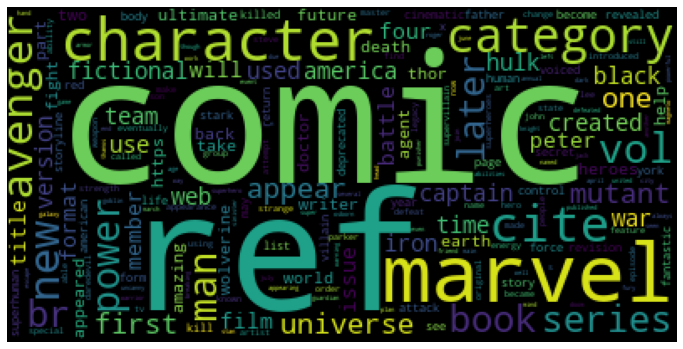

In [48]:
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(
                    stopwords=STOPWORDS,
                    background_color='black',
                    collocations=False
                    ).generate(marvel_string)

plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Part 4: Community detection
### Exercise 2: Use the concept of modularity to explore how community-like the universes are.

#### Explain the concept of modularity in your own words.

The concept of modularity explains the denseness of the connectivity of a graph. A module of a network is densely connected between the nodes in the module but has very few connections to other modules.

#### Consider the undirected version of the entire network, including both DC and Marvel.

In [49]:
from networkx.readwrite import json_graph
import json
import networkx as nx

In [50]:
# Load super network
with open(f"supernetwork.json", "r") as infile:
    json_data = json.load(infile)
    G_superhero = json_graph.adjacency_graph(json_data)

In [51]:
# Get the largest component
superhero_subgraphs = [G_superhero.subgraph(
    c).copy() for c in nx.weakly_connected_components(G_superhero)]
GC_superhero = max(superhero_subgraphs, key=len)

In [52]:
# Create the undirected graph
GC_super_un = GC_superhero.to_undirected()

#### Now create your own partition into communities, where all Marvel-characters are one community and all the DC-characters are another community. 
That's all you need, **now calculate the modularity of this partition.** Modularity is described in the Network Science book, section 9.4.. Thus, use **equation 9.12** in the book to calculate the modularity M of the partition described above. Are the universes good communities?

In [53]:
# Build a strictly marvel based network..
marvel_nodes = (node for node, data in GC_super_un.nodes(data=True) if data.get("universe") == "marvel")
G_marvel_un = GC_super_un.subgraph(marvel_nodes)

In [54]:
# Build a strictly dc based network..
dc_nodes = (node for node, data in GC_super_un.nodes(data=True) if data.get("universe") == "dc")
G_dc_un = GC_super_un.subgraph(dc_nodes)

In [55]:
from networkx.algorithms.community.quality import modularity

# Calculate modularity
modularity(GC_super_un, [G_marvel_un, G_dc_un])

0.3012721098372341

#### Would you expect this result in light of what we have found in the previous exercises?

The modularity of the network is between being optimal and sub-optimal. From looking at the graph representation of the network it makes sense that it is between the sub-optimal modularity and the optimal modularity as even though there are many connections between each community, there are also a lot of connections between the two communities. This makes sense as there are also some characters that are present in both universes connecting them to each other.

### Exercise 3: Community detection, considering each universe separately.

#### Consider the network of heroes for each universe separately.
* For this exercise, it's OK to just pick one of the universes.
* If you want to work with the entire network. Then run community detection on each universe separately, then combine results to get a list containing all communities from both parts of the network.
* (The reason for this is that the strong split between Marvel/DC universes can confuse the algorithm a bit).

#### Use the Python Louvain-algorithm implementation to find communities each network. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the universes as communities? What does this comparison reveal about them?
* This implementation is also available as Anaconda package. Install with `conda` as expained here.
* You can also try the Infomap algorithm instead if you're curious. Go to [this page]. (http://www.mapequation.org/code.html) and search for 'python'. It's harder to install, but a better community detection algorithm.

In [56]:
print(nx.info(G_marvel_un))

Name: 
Type: Graph
Number of nodes: 1190
Number of edges: 14025
Average degree:  23.5714


In [57]:
import community

partition_marvel = community.best_partition(G_marvel_un)

# Get lists of partitions
partition_list_marvel = {}
for pair in partition_marvel.items():
    if pair[1] not in partition_list_marvel.keys():
        partition_list_marvel[pair[1]] = []

    partition_list_marvel[pair[1]].append(pair[0])

modularity(G_marvel_un, partition_list_marvel.values())

0.37785047708923136

In [58]:
partition_dc = community.best_partition(G_dc_un)

# Get lists of partitions
partition_list_dc = {}
for pair in partition_dc.items():
    if pair[1] not in partition_list_dc.keys():
        partition_list_dc[pair[1]] = []

    partition_list_dc[pair[1]].append(pair[0])

modularity(G_dc_un, partition_list_dc.values())

0.28470303237823513

**SAY SOMETHING ABOUT THE MODULARITIES**

#### Visualize the network, using the Force Atlas algorithm (see Lecture 5, exercise 2). This time assign each node a different color based on their community. Describe the structure you observe.

100%|██████████| 500/500 [00:07<00:00, 68.77it/s]


BarnesHut Approximation  took  3.28  seconds
Repulsion forces  took  3.64  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.07  seconds
AdjustSpeedAndApplyForces step  took  0.13  seconds


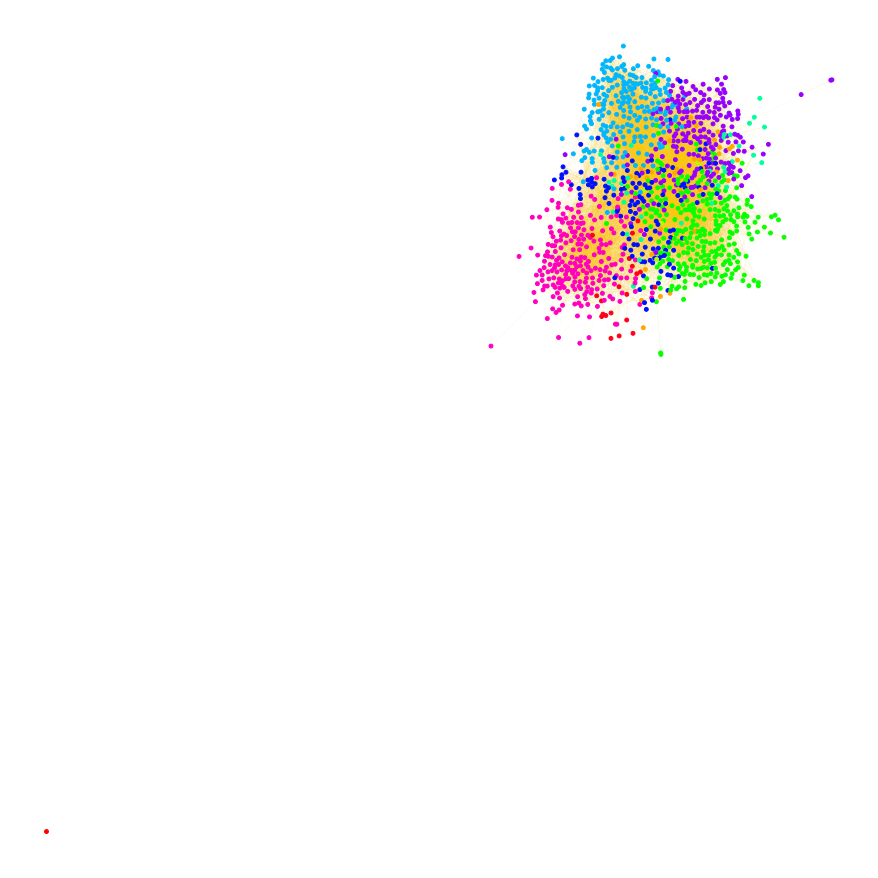

In [59]:
from fa2 import ForceAtlas2
import matplotlib.cm as cm

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=True,
                        gravity=5,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G_marvel_un, pos=None, iterations=500)

plt.figure(figsize=(12, 12))
# color the nodes according to their partition
cmap = cm.get_cmap('hsv', max(partition_marvel.values()) + 1)
nx.draw(G_marvel_un, pos=positions, with_labels=False, node_size=15, width=0.05, 
        cmap=cmap, node_color=list(partition_marvel.values()), edge_color='#f9c80e')
plt.show()

## Part 6: Communities TF-IDF word-clouds

#### You probably have a lot of communities (and there's probably a power-law distribution of sizes), so there are too many communities for us to work with all of them. Let's just grab the 10 largest communities.

In [60]:
sorted_communities = sorted(partition_list_marvel.items(), key=lambda x: len(x[1]), reverse=True)

#### For each community, create a single document for each community consisting of all the cleaned text from all members of the community. So in the end, you should have 10 documents in total.

In [61]:
df_marvel = df_superhero[df_superhero['universe'] == 'marvel']
community_text = {}

#Iterate over each community
for comm_list in sorted_communities:
    #create a item in the dict with key = community number, and value = empty string
    community_text[comm_list[0]] = ''
    #iterate through each node in the community
    for node in comm_list[1]:
        #to identify the associated filename and append wikitext, iterate through the dataframe
        for wikilink, file in zip(df_marvel.WikiLink, df_marvel.file):
        #match the node name with wikilink, and add the text of the node using the file-name association and json loads
            if node == wikilink[0]:
                    with open(f"../wikidata/{file}", "r") as infile:
                        jsonwiki = json.load(infile)
                        #converts the json to a string
                        text_content = str(jsonwiki['query']['pages'])
                        #appends the text of a given character to the community
                        community_text[comm_list[0]] += text_content

### Exercise 5
#### Now that we have the community-texts, let's start by calculating the TF list for each community (use whichever version of TF you like). Find the top 5 terms within each universe.

#### Next, calculate IDF for every word in every list (use whichever version of IDF you like).
* Which base logarithm did you use? Is that important?

#### We're now ready to calculate TF-IDFs. Do that for each community.
* List the 10 top words for each universe accourding to TF-IDF. Are these 10 words more descriptive of the universe than just the TF? Justify your answer.

#### Create a wordcloud for each community.

#### Explain your creation. Do the wordclouds/TF-IDF lists enable you to understand the communities you have found (or is it just gibberish)? Justify your answer.